# Covid19 - Brazil (Cities) Basic Graph Analysis
PORTUGUESE VERSION
- by Marcelo Rovai
- 02 June 2020

## Main Libraries and setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import plotly
import plotly.graph_objs as go
import bar_chart_race as bcr

In [2]:
from cv_util_func import *

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
pd.set_option('display.float_format', lambda x: '%.f' % x)
pd.options.plotting.backend = "plotly"
pd.options.display.float_format = '{:,}'.format
mpl.rcParams['figure.dpi'] = 150
plt.style.use('seaborn-paper')


## Datasets

### Worldometers Daily Data

- Based on TDS article: [Track Coronavirus in Your Country by Displaying Notifications Using Python](https://towardsdatascience.com/coronavirus-track-coronavirus-in-your-country-by-displaying-notification-c914b5652088)

In [5]:
worldmetersLink = "https://www.worldometers.info/coronavirus/"

In [6]:
data_wd_covid_br, today = get_wordometers_covid('Brazil', worldmetersLink)
# Saving Brazil info
Total_infected = data_wd_covid_br[0]
New_Cases = data_wd_covid_br[1]
Total_Deaths = data_wd_covid_br[2]
New_Deaths = data_wd_covid_br[3] 
Recovred = data_wd_covid_br[4] 
Active_Case = data_wd_covid_br[5] 
Serious_Critical = data_wd_covid_br[6]
date = today


Brazil - Worldometers Daily Data

Today is 2020-07-07 10:56:51.626225 
- Total infected = 1.628.283 
- New Cases = 2.212 
- Total Deaths = 65.631 
- New Deaths = 75 
- Recovered = 1.072.229 
- Active Cases = 93.614 
- Serious-Critical = 490.423


### Covid19

Confirmed cases by day, using information from the news. Covid19br dataset is available at GitHub https://github.com/wcota/covid19br, with data by city compiled from original dataset provided by [Brasil.IO](https://brasil.io/dataset/covid19/caso/). <br>
Thanks to: 
- [Wesley Cota](https://wesleycota.com), PhD candidate - Complex Networks/Physics (Universidade Federal de Viçosa - Brazil and Universidad de Zaragoza - Spain) 
- [Alvaro Justen](https://blog.brasil.io/author/alvaro-justen.html) from [Brasil.IO](https://brasil.io/dataset/covid19/caso/).

License: [Creative Commons Attribution-ShareAlike 4.0 International (CC BY-SA 4.0)](https://creativecommons.org/licenses/by-sa/4.0/)

More information: https://wcota.me/covid19br and [ESPECIAL COVID-19 - Dados por Município](https://brasil.io/covid19/)

**Number of total cases by city** 

In [7]:
today = datetime.datetime.today()

In [73]:
def get_brazil_cv_data(date, save=True):

    url = 'https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-cities.csv'
    url_st = 'https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-states.csv'
    url_tm = 'https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-cities-time.csv'
    dt = pd.read_csv(url, error_bad_lines=False)
    dt_st = pd.read_csv(url_st, error_bad_lines=False)
    dt_tm = pd.read_csv(url_tm, error_bad_lines=False)
    print("\nToday is {}/{}/{}. Dataset with {} observations.\n".format(
        date.year, date.month, date.day, dt.shape[0]))

    file = '../data/cases-brazil-cities-'+str(date.day)+'-'+str(date.month)+'-'+str(date.year)+'.csv'
    if save == True:
        dt.to_csv(file)

    dt.rename(columns={'ibgeID':'COD. IBGE'}, inplace=True)
    total_cases = dt.totalCases.sum()
    deaths = dt.deaths.sum()
    cfr = round ((deaths/total_cases)*100, 2)
    print('\nTotal number of cases in Brasil at {}/{}: {:,} ({} fatal) with a CFR of {}%'.format(
    date.month, date.day, total_cases, deaths, cfr))
    dt['CFR[%]'] = round((dt.deaths/dt.totalCases)*100, 2)
    dt.fillna(0, inplace=True)

    dt_state = dt.groupby('state')[['deaths','totalCases']].sum().reset_index()
    dt_state['CFR[%]'] = round((dt_state.deaths/dt_state.totalCases)*100, 2)

    dt_tm_city = dt_tm.loc[(dt_tm['state'] != 'TOTAL')].copy()
    dt_tm_city.rename(columns={'ibgeID':'COD. IBGE'}, inplace=True)

    return dt, dt_st, dt_tm, dt_tm_city, dt_state, total_cases, deaths, cfr

In [74]:
dt, dt_st, dt_tm, dt_tm_city, dt_state, total_cases, deaths, cfr = get_brazil_cv_data(
    today, save=False)


Today is 2020/7/7. Dataset with 5281 observations.


Total number of cases in Brasil at 7/7: 1,628,509 (65600 fatal) with a CFR of 4.03%


In [9]:
dt_tm.head(2)

epi_week        date country  state          city   ibgeID  \
0         9  2020-02-25  Brazil     SP  São Paulo/SP  3550308   
1         9  2020-02-25  Brazil  TOTAL         TOTAL        0   

   cod_RegiaoDeSaude name_RegiaoDeSaude  newDeaths  deaths  newCases  \
0           35,016.0          São Paulo          0       0         1   
1                nan                NaN          0       0         1   

   totalCases  deaths_per_100k_inhabitants  totalCases_per_100k_inhabitants  \
0           1                          0.0             0.008159999999999999   
1           1                          0.0           0.00047999999999999996   

   deaths_by_totalCases _source  
0                   0.0     SES  
1                   0.0     NaN

## Plot a Resumen Tables

### Worldometer

In [10]:
def plot_wm_table_pt(country, worldmetersLink, show=False, save=True):
    if country == 'World': pais = 'Mundo'
    elif country == 'South America': pais = 'America do Sul'
    elif country == 'Brazil': pais = 'Brasil'
    else: pais = 'Outros'
        
    data_wm, today = get_wordometers_covid(country, worldmetersLink)
    wm_date = str(today.day)+'/'+ str(today.month) +'/'+ str(today.year) +' - '+str(today.hour)+'h'
    wm = ['Total Infectados', 'Novos Casos', 'Total Óbitos', 'Novos Óbitos', 'Recuperados', 'Casos Ativos' , 'Casos Críticos']

    fig = go.Figure(data=[
        go.Table(header=dict(values=['www.wordometers.info', 'Dados'],
                             fill_color='#D6D6D6',
                             align=['center', 'center'],
                             font=dict(color='green', size=16)),
                 cells=dict(
                     values=[wm, data_wm],
                     fill_color="#E5ECF6",
                     align=['center', 'center'],
                     font=dict(color='firebrick', size=15),
                     height=30))
    ])
    fig.update_layout(
        title='Covid-19: {} - dados de {}'.format(pais, wm_date),
        font=dict(size=14, color="#7f7f7f"),
        margin=dict(l=20, r=20, t=50, b=20),
        autosize=False,
        width=600,
        height=310,
        )

    if save == True:
        fig.write_image('../graphs/wm_'+country+'_table_pt.png')
    if show == True:
        fig.show()

In [11]:
plot_wm_table_pt('World', worldmetersLink, show=True, save=False)


World - Worldometers Daily Data

Today is 2020-07-07 10:57:05.290350 
- Total infected = 11.780.676 
- New Cases = 47.680 
- Total Deaths = 541.781 
- New Deaths = 1.644 
- Recovered = 6.775.498 
- Active Cases = 138.032 
- Serious-Critical = 4.463.397


In [12]:
plot_wm_table_pt('South America', worldmetersLink, show=True, save=False)


South America - Worldometers Daily Data

Today is 2020-07-07 10:57:09.611678 
- Total infected = 2.552.941 
- New Cases = 3.424 
- Total Deaths = 95.062 
- New Deaths = 137 
- Recovered = 1.662.055 
- Active Cases = 95.440 
- Serious-Critical = 795.824


In [13]:
plot_wm_table_pt('Brazil', worldmetersLink, show=True, save=False)


Brazil - Worldometers Daily Data

Today is 2020-07-07 10:57:12.365365 
- Total infected = 1.628.283 
- New Cases = 2.212 
- Total Deaths = 65.631 
- New Deaths = 75 
- Recovered = 1.072.229 
- Active Cases = 93.614 
- Serious-Critical = 490.423


### GeoData Table

In [14]:
br_shp, br_cities = load_geodata()

Number of Brazilian Cities: 5,570
Total Brazilian Population: 210,147,125
Total Brazilian Territory : 8,985,590.0 km2 (aprox.)
Average Demografic Density : 23.0 hab/km2 (aprox.)


In [15]:
cv_city, deaths_city, cv_city_pnt, deaths_city_pnt, total_cases, deaths, cfr, number_cities_cases, number_cities_deaths = get_Brazil_data(
    dt, br_shp, br_cities)

Brazil: Total number of Covid19 cases at 7/7: 1,628,509 (65,600 fatal) in 5,258 cities with a CFR of 4.03%


In [16]:
perc_cases = round((number_cities_cases/5570)*100, 0)
perc_deaths = round((number_cities_deaths/5570)*100, 0)

In [17]:
geo = [
    'Total number of Cases', 'Total number of Deaths', 'CFR [%]',
    'Total number of Brazil cities', 'Number of Identified cities with cases',
    'Brazilian cities with cases [%]',
    'Number of Identified cities with deaths',
    'Brazilian cities with deaths [%]'
]
data_geo = [
    total_cases, deaths, cfr, 5570, number_cities_cases, perc_cases,
    number_cities_deaths, perc_deaths
]

In [18]:
def plot_geo_table_pt(today, geo, data_geo, show=False, save=True):
    
    geo_labels = [
     'Número total de casos', 'Número total de óbitos', 'CFR [%]',
     'Número total de cidades do Brasil', 'Número de cidades identificadas com casos',
     'Cidades brasileiras com casos [%]',
     'Número de cidades identificadas com óbitos',
     'Cidades brasileiras com óbitos [%]'
    ]
    data_geo = [f'{v:,}'.replace(',', '.') for v in data_geo]
    data_geo[2] = data_geo[2].replace('.', ',')
    data_geo[-1] = data_geo[-1].replace('.', ',')
    data_geo[-3] = data_geo[-3].replace('.', ',')
    geo_date = str(today.day)+'/'+ str(today.month) +'/'+ str(today.year) +' - '+str(today.hour)+'h'

    fig = go.Figure(data=[
        go.Table(header=dict(values=['Sumário Geográfico', 'Dados - Brasil'],
                             fill_color='#D6D6D6',
                             align=['center', 'center'],
                             font=dict(color='green', size=16)),
                 cells=dict(
                     values=[geo_labels, data_geo],
                     fill_color="#E5ECF6",
                     align=['right', 'center'],
                     font=dict(color='firebrick', size=15),
                     height=30))
    ])
    fig.update_layout(
        title='Sumário de dados geográficos - Brasil - {}'.format(geo_date),
        font=dict(size=16, color="#7f7f7f"),
        margin=dict(l=20, r=20, t=50, b=20),
        autosize=False,
        width=800,
        height=350,
        )

    if save == True:
        fig.write_image('../graphs/geo_table_pt.png')
    if show == True:
        fig.show()

In [19]:
plot_geo_table_pt(today, geo, data_geo, show=True, save=False)

### Total cases by state

In [87]:
dx.columns

Index(['epi_week', 'date', 'country', 'state', 'city', 'newDeaths', 'deaths',
       'newCases', 'totalCases', 'deathsMS', 'totalCasesMS',
       'deaths_per_100k_inhabitants', 'totalCases_per_100k_inhabitants',
       'deaths_by_totalCases', 'recovered', 'suspects', 'tests',
       'tests_per_100k_inhabitants'],
      dtype='object')

In [105]:
def plot_table(dx, show=False, save=True):
    date = datetime.datetime.today()
    
    deaths = dx.deaths
    deaths = [f'{v:,}'.replace(',', '.') for v in deaths]
    
    recovered = dx.recovered
    recovered = [f'{v:,}'.replace(',', '.') for v in recovered]
    
    suspects = dx.suspects
    suspects = [f'{v:,}'.replace(',', '.') for v in suspects]
    
    tests = dx.recovered
    tests = [f'{v:,}'.replace(',', '.') for v in tests]
    
    totalCases = dx.totalCases
    totalCases = [f'{v:,}'.replace(',', '.') for v in totalCases]  
    
    dados = [dx.state, recovered, deaths, totalCases, suspects, tests]
    labels = ['Estado', 'Recuperados', 'Óbitos', 'Casos', 'Suspeitos', 'Testes']

    fig = go.Figure(data=[
        go.Table(header=dict(values=labels,
                             fill_color='#D6D6D6',
                             align=['center', 'center'],
                             font=dict(color='green', size=16)),
                 cells=dict(
                     values=dados,
                     fill_color="#E5ECF6",
                     align=['center', 'center'],
                     font=dict(color='firebrick', size=15),
                     height=30))
    ])
    fig.update_layout(
        title='Covid-19 Informações por estado brasileiro - {}/{}/{}'.format(
            date.day,
            date.month,
            date.year,
        ),
        font=dict(size=16, color="#7f7f7f"),
        margin=dict(l=20, r=20, t=50, b=20),
        autosize=False,
        width=700,
        height=980,
    )

    if save == True:
        fig.write_image('../graphs/state_table.png')
    if show == True:
        fig.show()

In [101]:
dt_st.tail()

epi_week        date country  state   city  newDeaths  deaths  newCases  \
3257        28  2020-07-06  Brazil     SC  TOTAL         13     406       853   
3258        28  2020-07-06  Brazil     SE  TOTAL         28     826       501   
3259        28  2020-07-06  Brazil     SP  TOTAL         56   16134      2891   
3260        28  2020-07-06  Brazil     TO  TOTAL          0     224         0   
3261        28  2020-07-06  Brazil  TOTAL  TOTAL        632   65600     22815   

      totalCases  deathsMS  totalCasesMS  deaths_per_100k_inhabitants  \
3257       33822       406         33822                       5.6666   
3258       30718       826         30718                     35.93342   
3259      323070     16134        323070                     35.13575   
3260       12640       224         12640           14.241520000000001   
3261     1628509     65487       1623284                     31.21623   

      totalCases_per_100k_inhabitants  deaths_by_totalCases  recovered  \
3257                        472.05863                 0.012      28115   
3258                      1,336.32285  0.026889999999999997      18949   
3259                        703.56422               0.04994     176494   
3260                        803.62854               0.01772       7850   
3261                        774.93756               0.04028    1062542   

      suspects    tests  tests_per_100k_inhabitants  
3257      4326   143943                 2,009.03362  
3258      8695    55826                  2,428.5943  
3259    281088   602384                 1,311.83901  
3260      2242    22854         1,453.0163400000001  
3261    787252  3889883         1,851.0284199999999

In [92]:
dt_st = dt_st.fillna(0)
dt_st['recovered'] = dt_st['recovered'].astype('int64')
dt_st['suspects'] = dt_st['suspects'].astype('int64')
dt_st['tests'] = dt_st['tests'].astype('int64')

In [93]:
date_today = list(dt_st.date[-2:-1])[0]
dt_st_today = dt_st[dt_st.date == date_today]
dt_st_today.shape

(28, 18)

In [94]:
dt_st_today.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28 entries, 3234 to 3261
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   epi_week                         28 non-null     int64  
 1   date                             28 non-null     object 
 2   country                          28 non-null     object 
 3   state                            28 non-null     object 
 4   city                             28 non-null     object 
 5   newDeaths                        28 non-null     int64  
 6   deaths                           28 non-null     int64  
 7   newCases                         28 non-null     int64  
 8   totalCases                       28 non-null     int64  
 9   deathsMS                         28 non-null     int64  
 10  totalCasesMS                     28 non-null     int64  
 11  deaths_per_100k_inhabitants      28 non-null     float64
 12  totalCases_per_100k

In [106]:
dx = dt_st_today.sort_values('deaths', ascending=False)
plot_table(dx, show=True, save=False)

## Maps

In [22]:
br_shp.head()

ID  COD. UF NM_ESTADO NM_REGIAO  UF  QTD_MUN  POP_2019   AREA_APROX  \
0   1       11  RONDONIA     NORTE  RO       52   1777225   246,684.97   
1   2       12      ACRE     NORTE  AC       22    881935   168,458.35   
2   3       13  AMAZONAS     NORTE  AM       62   4144597  1,571,148.4   
3   4       14   RORAIMA     NORTE  RR       15    605761   224,721.09   
4   5       15      PARA     NORTE  PA      144   8602865 1,255,358.39   

   DENS_DEMOG                                           geometry  
0         7.2  POLYGON ((-63.32721 -7.97672, -63.11838 -7.977...  
1        5.24  POLYGON ((-73.18253 -7.33550, -73.13680 -7.352...  
2        2.64  POLYGON ((-67.32609 2.02971, -67.31682 2.00125...  
3         2.7  POLYGON ((-60.20051 5.26434, -60.19828 5.26045...  
4        6.85  MULTIPOLYGON (((-54.95431 2.58369, -54.93542 2...

In [23]:
br_shp.shape

(27, 10)

In [107]:
dt_st_today.head()

epi_week        date country state   city  newDeaths  deaths  newCases  \
3234        28  2020-07-06  Brazil    AC  TOTAL          3     394        66   
3235        28  2020-07-06  Brazil    AL  TOTAL         19    1172       634   
3236        28  2020-07-06  Brazil    AM  TOTAL          9    2938       413   
3237        28  2020-07-06  Brazil    AP  TOTAL          7     449       121   
3238        28  2020-07-06  Brazil    BA  TOTAL         61    2168      1231   

      totalCases  deathsMS  totalCasesMS  deaths_per_100k_inhabitants  \
3234       14688       394         14688           44.674490000000006   
3235       40569      1172         40569                     35.11761   
3236       76427      2938         76424                     70.88747   
3237       30004       449         30004            53.09016999999999   
3238       88279      2168         88279                     14.57669   

      totalCases_per_100k_inhabitants  deaths_by_totalCases  recovered  \
3234                      1,665.42886               0.02682       8243   
3235                      1,215.60265               0.02889      32468   
3236                      1,844.01523  0.038439999999999995      61989   
3237              3,547.7001600000003               0.01496      17850   
3238                        593.54952               0.02456      59779   

      suspects   tests  tests_per_100k_inhabitants  
3234       189   34332         3,892.8038899999997  
3235      1969   86736         2,598.9428199999998  
3236      2446  174415                 4,208.24992  
3237      4429   52726                 6,234.37003  
3238     87239  268503                 1,805.29715

In [111]:
state = dt_st_today.copy()
#state.columns = ['UF', 'Óbitos', 'Casos', 'CFR[%]']
state.rename(columns={'state':'UF'}, inplace = True)
state.head()

epi_week        date country  UF   city  newDeaths  deaths  newCases  \
3234        28  2020-07-06  Brazil  AC  TOTAL          3     394        66   
3235        28  2020-07-06  Brazil  AL  TOTAL         19    1172       634   
3236        28  2020-07-06  Brazil  AM  TOTAL          9    2938       413   
3237        28  2020-07-06  Brazil  AP  TOTAL          7     449       121   
3238        28  2020-07-06  Brazil  BA  TOTAL         61    2168      1231   

      totalCases  deathsMS  totalCasesMS  deaths_per_100k_inhabitants  \
3234       14688       394         14688           44.674490000000006   
3235       40569      1172         40569                     35.11761   
3236       76427      2938         76424                     70.88747   
3237       30004       449         30004            53.09016999999999   
3238       88279      2168         88279                     14.57669   

      totalCases_per_100k_inhabitants  deaths_by_totalCases  recovered  \
3234                      1,665.42886               0.02682       8243   
3235                      1,215.60265               0.02889      32468   
3236                      1,844.01523  0.038439999999999995      61989   
3237              3,547.7001600000003               0.01496      17850   
3238                        593.54952               0.02456      59779   

      suspects   tests  tests_per_100k_inhabitants  
3234       189   34332         3,892.8038899999997  
3235      1969   86736         2,598.9428199999998  
3236      2446  174415                 4,208.24992  
3237      4429   52726                 6,234.37003  
3238     87239  268503                 1,805.29715

In [113]:
state = pd.merge(br_shp, state, on='UF')
state.shape

(27, 27)

In [114]:
state.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 27 entries, 0 to 26
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   ID                               27 non-null     int64   
 1   COD. UF                          27 non-null     int64   
 2   NM_ESTADO                        27 non-null     object  
 3   NM_REGIAO                        27 non-null     object  
 4   UF                               27 non-null     object  
 5   QTD_MUN                          27 non-null     int64   
 6   POP_2019                         27 non-null     int64   
 7   AREA_APROX                       27 non-null     float64 
 8   DENS_DEMOG                       27 non-null     float64 
 9   geometry                         27 non-null     geometry
 10  epi_week                         27 non-null     int64   
 11  date                             27 non-null     object  
 12  co

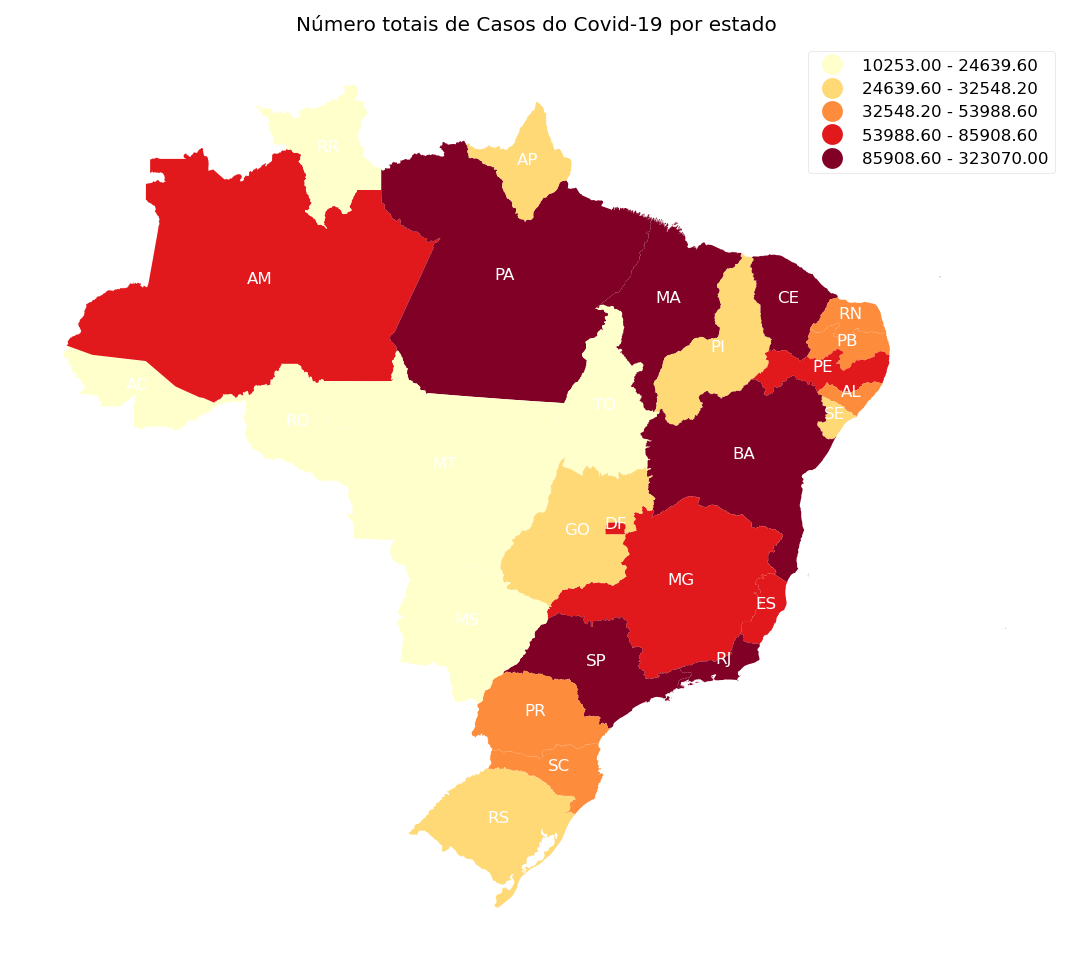

In [116]:
ax = state.plot(column='totalCases',
                   cmap='YlOrRd',
                   scheme='quantiles',
                   legend=True,
                   figsize=(12, 8))
plt.title("Número totais de Casos do Covid-19 por estado ")
ax.set_axis_off()
for idx, row in state.iterrows():
    plt.annotate(s=row['UF'],
                 xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                 horizontalalignment='center',
                 fontsize=8,
                 color='white')

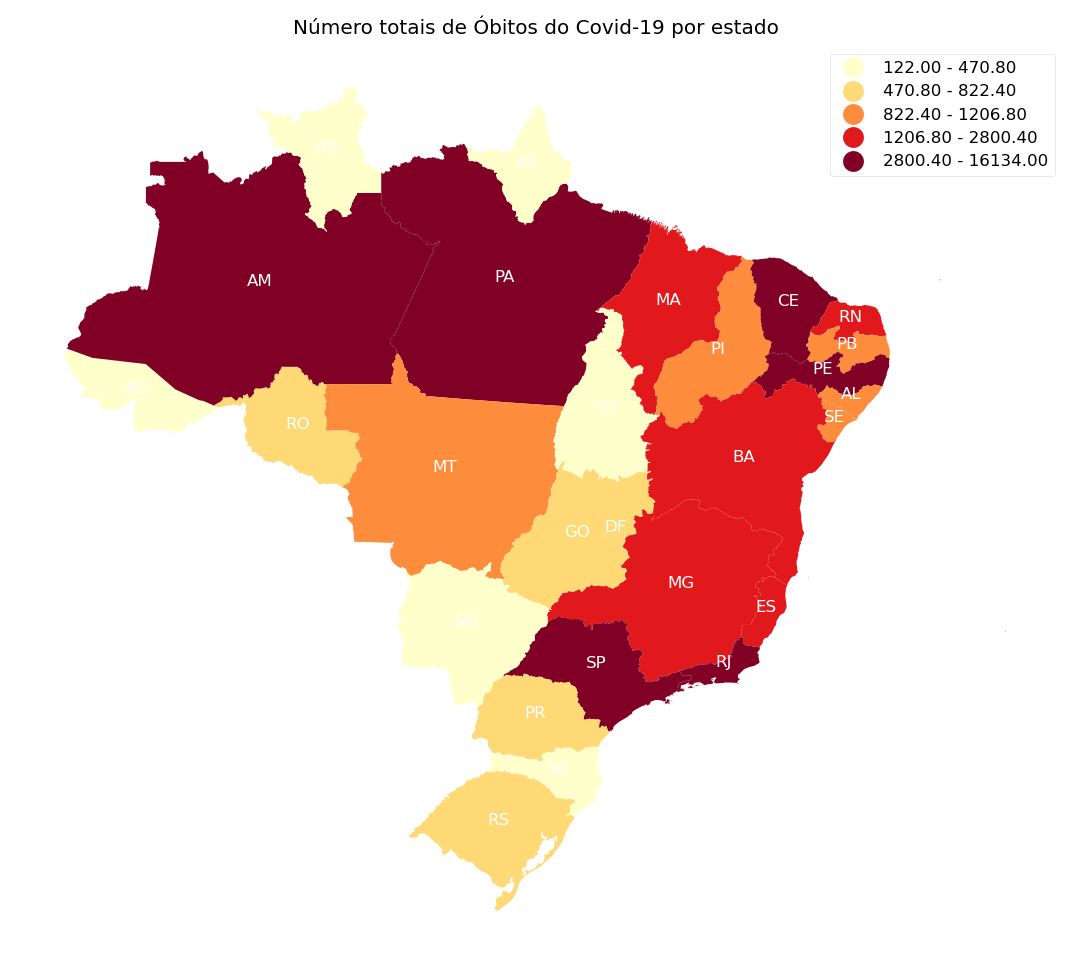

In [117]:
ax = state.plot(column='deaths',
                   cmap='YlOrRd',
                   scheme='quantiles',
                   legend=True,
                   figsize=(12, 8))
plt.title("Número totais de Óbitos do Covid-19 por estado ")
ax.set_axis_off()
for idx, row in state.iterrows():
    plt.annotate(s=row['UF'],
                 xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                 horizontalalignment='center',
                 fontsize=8,
                 color='white')

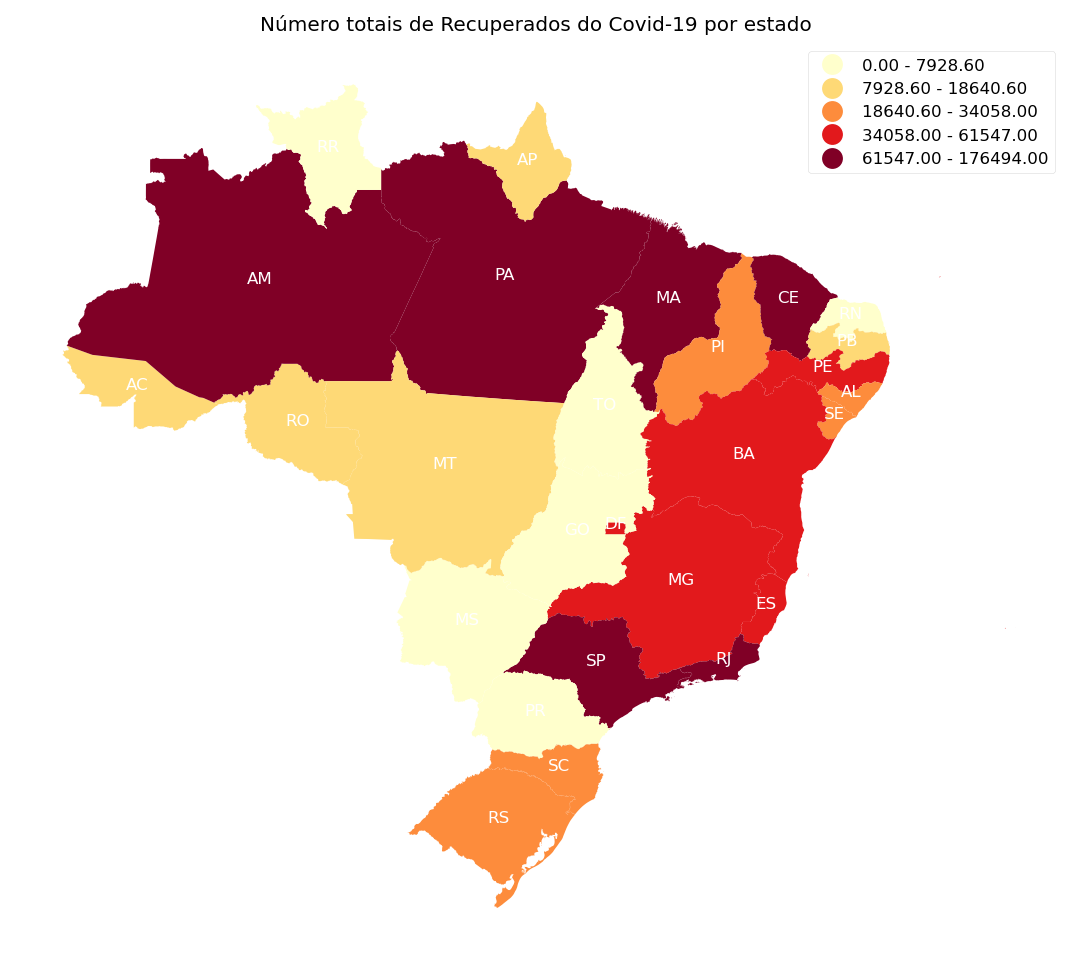

In [119]:
ax = state.plot(column='recovered',
                   cmap='YlOrRd',
                   scheme='quantiles',
                   legend=True,
                   figsize=(12, 8))
plt.title("Número totais de Recuperados do Covid-19 por estado ")
ax.set_axis_off()
for idx, row in state.iterrows():
    plt.annotate(s=row['UF'],
                 xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                 horizontalalignment='center',
                 fontsize=8,
                 color='white')

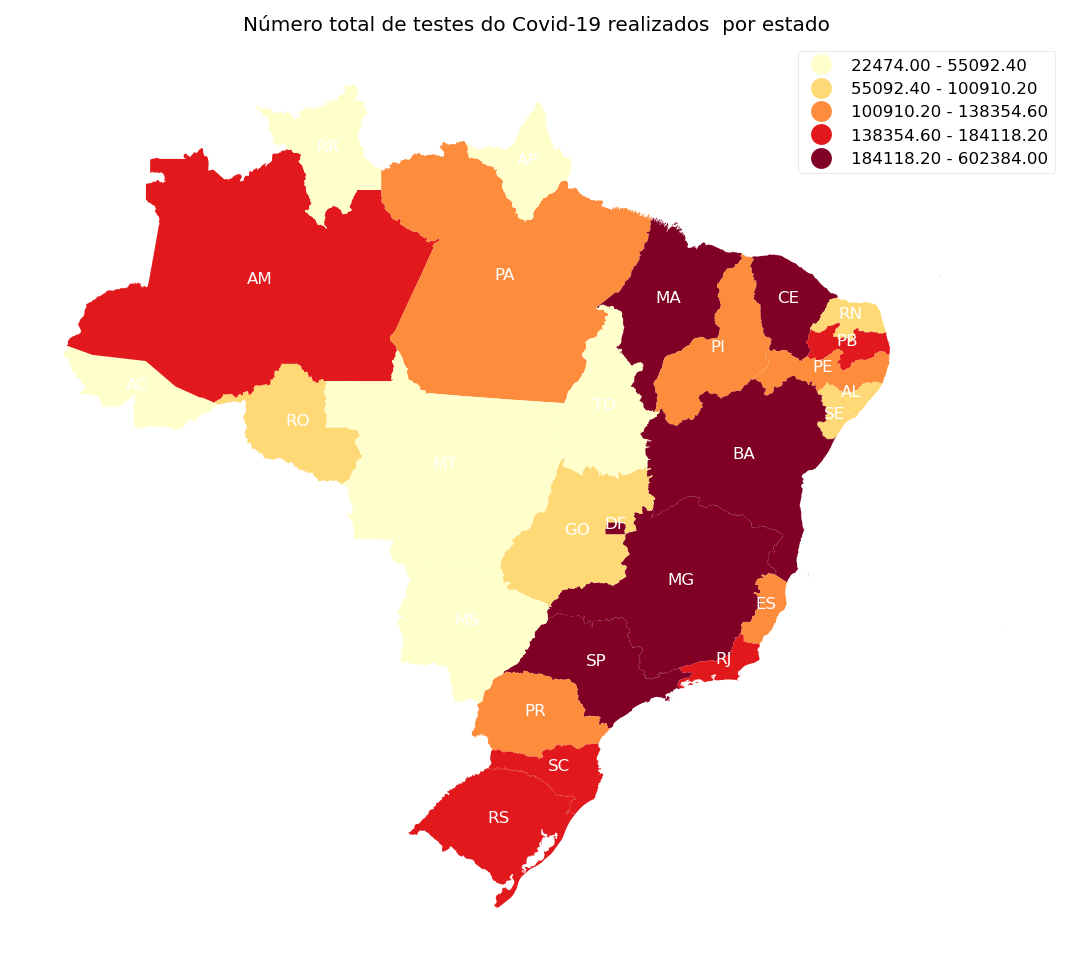

In [121]:
ax = state.plot(column='tests',
                   cmap='YlOrRd',
                   scheme='quantiles',
                   legend=True,
                   figsize=(12, 8))
plt.title("Número total de testes do Covid-19 realizados  por estado ")
ax.set_axis_off()
for idx, row in state.iterrows():
    plt.annotate(s=row['UF'],
                 xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                 horizontalalignment='center',
                 fontsize=8,
                 color='white')

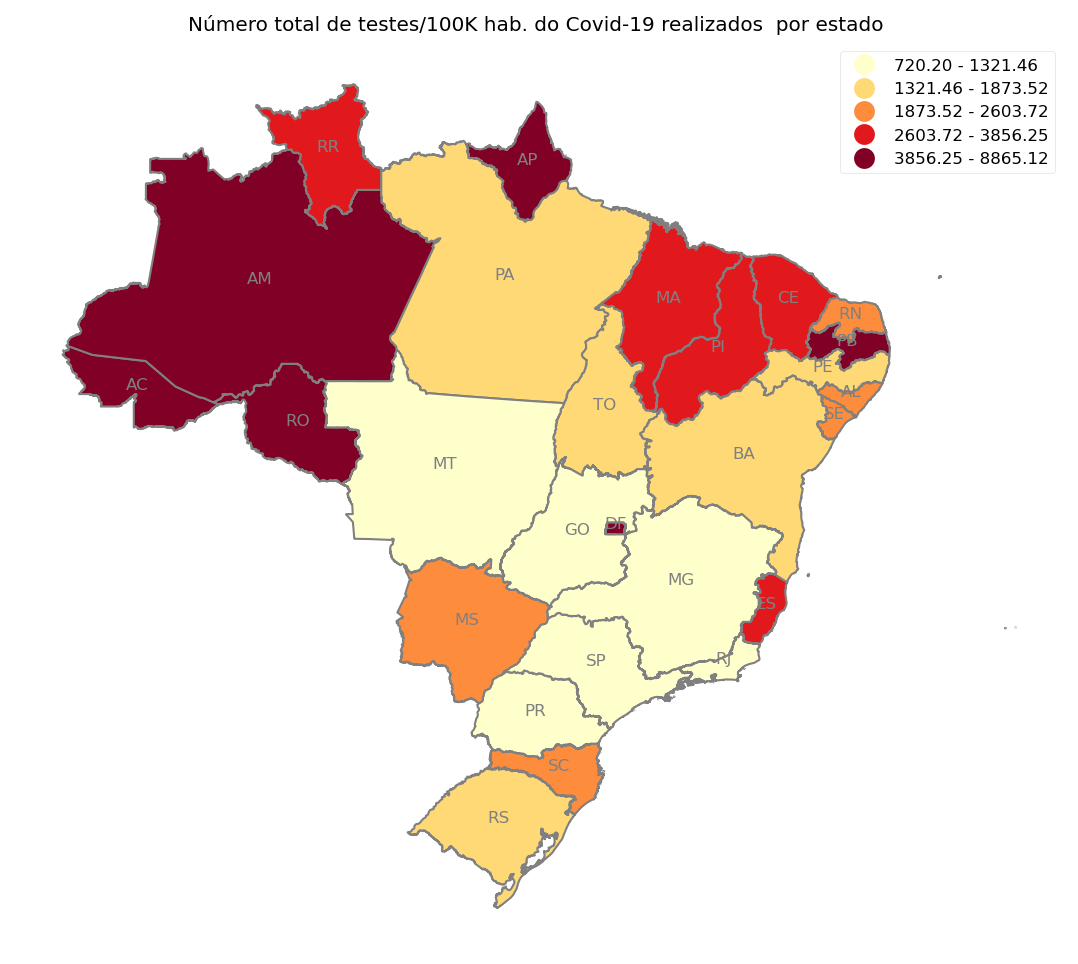

In [128]:
ax = state.plot(column='tests_per_100k_inhabitants',
                   cmap='YlOrRd',
                   scheme='quantiles',
                   legend=True,
                   figsize=(12, 8),
                   edgecolor='gray',
                   linewidth=1)
plt.title("Número total de testes/100K hab. do Covid-19 realizados  por estado ")
ax.set_axis_off()
for idx, row in state.iterrows():
    plt.annotate(s=row['UF'],
                 xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                 horizontalalignment='center',
                 fontsize=8,
                 color='gray')

In [29]:
def plt_Brasil_cities(cv_city,
                      deaths_city,
                      date,
                      total_cases,
                      deaths,
                      cfr,
                      br_shp, br_cities,
                      deaths_only=False):
    ax = br_shp.plot(figsize=(18, 16), color='#FFFFFF', edgecolor='#444444')
    if deaths_only == False:
        cv_city.plot(ax=ax, color="orange", markersize=5, label='City')
    deaths_city.plot(ax=ax,
                     color="red",
                     markersize=5,
                     label='City with Deaths')
    plt.title(
        'Brazil: Covid19 total cases at {}/{}/{}: {:,} ({:,} fatal in red) in {:,} identified cities\
        \nCFR: {}% - Total data includes cases/deaths with not identified cities'
        .format(date.year, date.month, date.day, total_cases, deaths,
                len(cv_city.index), cfr),
        fontsize=20,
        loc='left')
    plt.axis('off')

    for idx, row in br_shp.iterrows():
        plt.annotate(s=row['UF'],
                     xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                     horizontalalignment='center',
                     fontsize=10,
                     color='green')

    plt.annotate('Map created by Marcelo Rovai (MJRoBot.org) @{}/{}/{}'.format(
        date.year, date.month, date.day),
                 xy=(0.55, .17),
                 xycoords='figure fraction',
                 horizontalalignment='left',
                 fontsize=12,
                 color='blue')
    plt.annotate('Data provided by https://brasil.io/dataset/covid19/caso/',
                 xy=(0.55, .16),
                 xycoords='figure fraction',
                 horizontalalignment='left',
                 fontsize=12,
                 color='blue')
    plt.annotate(
        'License: CC BY-SA 4.0 (https://creativecommons.org/licenses/by-sa/4.0/',
        xy=(0.55, .15),
        xycoords='figure fraction',
        horizontalalignment='left',
        fontsize=12,
        color='blue')

    file_today = '../images/!cv19_BR_last_updated.png'
    file = '../images/cv19_Brazil_' + str(date.month) + '-' + str(
        date.day) + '-' + str(date.year) + '.png'
    #file_gif = '../br_images_gif/today_cv19_Brazil.png'

    if deaths_only == False:
        #plt.savefig(file, dpi=300)
        plt.savefig(file_today, dpi=300)
        #plt.savefig(file_gif, dpi=200)



## Timelines

### Timeline Brazil

In [30]:
plot_cases(dt_tm, 'TOTAL', y_scale='linear', n_0=1000, mov=7, show=True, save=False)

In [31]:
plot_cases(dt_tm, 'TOTAL', y_scale='log', n_0=1000, mov=7, show=True, save=False)

### Timeline of cases per city**

In [32]:
top_cities = list(dt.sort_values('totalCases', ascending=False)[:10].city)
top_cities

['São Paulo/SP',
 'Rio de Janeiro/RJ',
 'Brasília/DF',
 'Salvador/BA',
 'Fortaleza/CE',
 'Manaus/AM',
 'Recife/PE',
 'Belém/PA',
 'Aracaju/SE',
 'Maceió/AL']

In [33]:
top_cities_deaths = list(dt.sort_values('deaths', ascending=False)[:15].city)
top_cities_deaths

['São Paulo/SP',
 'Rio de Janeiro/RJ',
 'Fortaleza/CE',
 'Belém/PA',
 'Recife/PE',
 'Manaus/AM',
 'Salvador/BA',
 'São Luís/MA',
 'Guarulhos/SP',
 'Brasília/DF',
 'Maceió/AL',
 'Jaboatão dos Guararapes/PE',
 'Natal/RN',
 'Osasco/SP',
 'São Gonçalo/RJ']

In [34]:
for city in top_cities:
    plot_cases(dt_tm, city, y_scale='linear', n_0=100, mov=7, show=True, save=False)
    plot_cases(dt_tm, city, y_scale='log', n_0=100, mov=7, show=True, save=False) 
    plot_mov_ave_deaths_last_week(dt_tm, city, y_scale='linear', n_0=3, mov=7, show=True, save=False)

### Specific cities analisis 

In [35]:
city = "Duque de Caxias/RJ"
plot_cases(dt_tm, city, y_scale='linear', n_0=100, mov=7, show=True, save=False)
plot_cases(dt_tm, city, y_scale='log', n_0=100, mov=7, show=True, save=False) 
plot_mov_ave_deaths_last_week(dt_tm, city, y_scale='linear', n_0=3, mov=7, show=True, save=False)

## Timeline New Deaths versus Previus Week 

In [36]:
def plot_mov_ave_deaths_last_week_2(data,
                                  city,
                                  n_0=100,
                                  y_scale='log',
                                  mov=7,
                                  graph='bar',
                                  show=False,
                                  save=True,
                                  rect=False,
                                  x0=None,
                                  x1=None,
                                  text=None):
    date = datetime.datetime.today()
    data = data[data.city == city]
    tst = data[data.deaths >= n_0]
    tst.reset_index(drop=True, inplace=True)

    tst['new_deaths'] = tst['deaths'] - tst['deaths'].shift(1)
    tst['new_deaths_Mov_Ave'] = tst.iloc[:, -1].rolling(window=mov).mean()
    tst['mov_ave_new_deaths_last_week'] = tst['new_deaths_Mov_Ave'] - tst[
        'new_deaths_Mov_Ave'].shift(7)
    fig = go.Figure()
    if graph == 'bar':
        fig.add_trace(
            go.Bar(x=tst.date,
                   y=round(tst.new_deaths_Mov_Ave),
                   name='New daily deaths'))
        fig.add_trace(
            go.Bar(x=tst.date,
                   y=round(tst.mov_ave_new_deaths_last_week),
                   name='New daily deaths vs last week'))
    else:
        fig.add_trace(
            go.Scatter(x=tst.date,
                       y=round(tst.new_deaths_Mov_Ave),
                       name='New daily Deaths',
                       line=dict(color='royalblue', width=2)))
        fig.add_trace(
            go.Scatter(x=tst.date,
                       y=round(tst.mov_ave_new_deaths_last_week),
                       name='New daily deaths vs last week',
                       line=dict(color='firebrick', width=2)))
    if rect == True:
        fig.update_layout(
            shapes=[
                # 1st highlight during Feb 4 - Feb 6
                dict(
                    type="rect",
                    # x-reference is assigned to the x-values
                    xref="x",
                    # y-reference is assigned to the plot paper [0,1]
                    yref="paper",
                    x0=x0,
                    y0=0,
                    x1=x1,
                    y1=1,
                    fillcolor="LightSalmon",
                    opacity=0.3,
                    layer="below",
                    line_width=0,
                )
            ],
            annotations=[
                dict(x=x0,
                     y=0.8,
                     xref="x",
                     yref='paper',
                     text=text,
                     showarrow=True,
                     font=dict(family="Courier New, monospace",
                               size=16,
                               color="#ffffff"),
                     align="center",
                     arrowhead=2,
                     arrowsize=1,
                     arrowwidth=2,
                     arrowcolor="#636363",
                     ax=20,
                     ay=-30,
                     bordercolor="#c7c7c7",
                     borderwidth=2,
                     borderpad=4,
                     bgcolor="#ff7f0e",
                     opacity=0.5)
            ])

    fig.update_layout(
        title='Brazil ({}) - New Daily Deaths by Covid-19 versus same day previous week'.
        format(city),
        xaxis_title="Day",
        yaxis_title="Number of Deaths",
        yaxis_type=y_scale,
        font=dict(size=10, color="#7f7f7f"),
        legend=dict(x=0,
                    y=1.0,
                    bgcolor='rgba(255, 255, 255, 0)',
                    bordercolor='rgba(255, 255, 255, 0)'),
        annotations=[
            dict(
                x=0,
                y=1.05,
                text='Deaths over {:,} - Y-scale: {} ({}-day rolling average) - {}/{}/{}'
                .format(n_0, y_scale, mov, date.year, date.month, date.day),
                showarrow=False,
                xref='paper',
                yref='paper',
                xanchor='left',
                yanchor='auto',
                xshift=0,
                yshift=0,
                font=dict(size=10, color="#7f7f7f")),
            dict(
                x=0,
                y=1.05,
                text='Deaths over {:,} - Y-scale: {} ({}-day rolling average) - {}/{}/{}'
                .format(n_0, y_scale, mov, date.year, date.month, date.day),
                showarrow=False,
                xref='paper',
                yref='paper',
                xanchor='left',
                yanchor='auto',
                xshift=0,
                yshift=0,
                font=dict(size=10, color="#7f7f7f")),
            dict(x=1,
                 y=-0.10,
                 text="Source: Brasil.io - https://brasil.io/dataset/covid19/caso/",
                 showarrow=False,
                 xref='paper',
                 yref='paper',
                 xanchor='right',
                 yanchor='auto',
                 xshift=0,
                 yshift=0,
                 font=dict(size=8, color='royalblue')),
            dict(x=1,
                 y=-0.14,
                 text="Created by Marcelo Rovai - https://MJRoBot.org",
                 showarrow=False,
                 xref='paper',
                 yref='paper',
                 xanchor='right',
                 yanchor='auto',
                 xshift=0,
                 yshift=0,
                 font=dict(size=8, color='royalblue'))
        ])

    if save == True:
        city = city.replace('/', '-')
        fig.write_image(
            '../graphs/cv19_' + city + '_' + graph +'_' + y_scale +
            '_CV_Mov_ave_deaths_last_week_Evolution_Graph_updated.png')
    if show == True:
        fig.show()

    return tst

In [37]:
tst = plot_mov_ave_deaths_last_week_2(dt_tm,
                                    'Fortaleza/CE',
                                    y_scale='linear',
                                    n_0=3,
                                    mov=7,
                                    graph='line',
                                    show=True,
                                    save=False,
                                    rect=True, 
                                    x0='2020-05-07',
                                    x1='2020-05-31',
                                    text="Lock-Down")

In [38]:
tst = plot_mov_ave_deaths_last_week_2(dt_tm,
                                    'São Paulo/SP',
                                    y_scale='linear',
                                    n_0=3,
                                    mov=7,
                                    graph='line',
                                    show=True,
                                    save=False,
                                    rect=True, 
                                    x0='2020-05-20',
                                    x1='2020-05-25',
                                    text="Holidays")

In [39]:
tst = plot_mov_ave_deaths_last_week_2(dt_tm,
                                    'Recife/PE',
                                    y_scale='linear',
                                    n_0=3,
                                    mov=7,
                                    graph='line',
                                    show=True,
                                    save=False,
                                    rect=True, 
                                    x0='2020-05-16',
                                    x1='2020-05-31',
                                    text="Lock-Down")

In [40]:
tst = plot_mov_ave_deaths_last_week_2(dt_tm,
                                    'Rio de Janeiro/RJ',
                                    y_scale='linear',
                                    n_0=3,
                                    mov=7,
                                    graph='line',
                                    show=True,
                                    save=False,
                                    rect=False, 
                                    x0='2020-05-07',
                                    x1='2020-05-25',
                                    text="Lock-Down")

In [41]:
tst = plot_mov_ave_deaths_last_week_2(dt_tm,
                                    'Manaus/AM',
                                    y_scale='linear',
                                    n_0=3,
                                    mov=7,
                                    graph='line',
                                    show=True,
                                    save=False,
                                    rect=False, 
                                    x0='2020-05-07',
                                    x1='2020-05-25',
                                    text="Lock-Down")

In [42]:
tst = plot_mov_ave_deaths_last_week_2(dt_tm,
                                    'Porto Velho/RO',
                                    y_scale='linear',
                                    n_0=1,
                                    mov=3,
                                    graph='line',
                                    show=True,
                                    save=False,
                                    rect=False, 
                                    x0='2020-05-07',
                                    x1='2020-05-25',
                                    text="Lock-Down")

In [43]:
plot_cases(dt_tm, 'Porto Velho/RO', y_scale='log', n_0=100, mov=7, show=True, save=False)

In [44]:
plot_cases(dt_tm, 'Porto Velho/RO', y_scale='log', n_0=100, mov=7, show=True, save=False)

In [45]:
plot_cases(dt_tm, 'Belo Horizonte/MG', y_scale='log', n_0=100, mov=7, show=True, save=False)

In [46]:
tst = plot_mov_ave_deaths_last_week_2(dt_tm,
                                    'Belo Horizonte/MG',
                                    y_scale='linear',
                                    n_0=3,
                                    mov=7,
                                    graph='line',
                                    show=True,
                                    save=False,
                                    rect=False, 
                                    x0='2020-05-07',
                                    x1='2020-05-25',
                                    text="Lock-Down")

In [47]:
tst = plot_mov_ave_deaths_last_week_2(dt_tm,
                                    'TOTAL',
                                    y_scale='linear',
                                    n_0=3,
                                    mov=7,
                                    graph='line',
                                    show=True,
                                    save=False,
                                    rect=False, 
                                    x0='2020-05-07',
                                    x1='2020-05-25',
                                    text="Lock-Down")

In [48]:
tst = plot_mov_ave_deaths_last_week_2(dt_tm,
                                    'Brasília/DF',
                                    y_scale='linear',
                                    n_0=1,
                                    mov=7,
                                    graph='line',
                                    show=True,
                                    save=False,
                                    rect=False, 
                                    x0='2020-05-07',
                                    x1='2020-05-25',
                                    text="Lock-Down")

In [49]:
tst[tst.date == '2020-05-08']

epi_week        date country state         city   ibgeID  \
40        19  2020-05-08  Brazil    DF  Brasília/DF  5300108   

    cod_RegiaoDeSaude name_RegiaoDeSaude  newDeaths  deaths  newCases  \
40           53,001.0   Distrito Federal          2      37       184   

    totalCases  deaths_per_100k_inhabitants  totalCases_per_100k_inhabitants  \
40        2442                      1.22709                         80.98783   

    deaths_by_totalCases _source  new_deaths  new_deaths_Mov_Ave  \
40               0.01515     SES         2.0  0.8571428571428571   

    mov_ave_new_deaths_last_week  
40            0.1428571428571428

# Other Graphics

## Multiple Cities

In [50]:
def get_dataframe(df, cities, feature, rnd=0, in_data='2020-04-01', mov=1, cmp_lst_week=False):
    data_city = pd.DataFrame(df.date)
    for city in cities:
        df_city = round(df[df.city == city][feature], rnd)
        data_city[city] = df_city
    data_city = data_city.fillna(0)
    #data_city = data_city[data_city.date > in_data]
    data_city = data_city.groupby('date').agg(np.sum)
    
    tst = data_city.copy()
    tst = round(tst.iloc[:].rolling(window=mov).mean(), 0)
    if cmp_lst_week:
        tst = tst - tst.shift(7)
    tst = tst[tst.index > in_data]
    return tst

In [51]:
def plot_cities(df, cities, feature, mov, title, order=4):
    dx = get_dataframe(df, cities, feature, mov)
    dx = dx.reset_index()
    fig = plt.figure(figsize=(15, 8))
    for city in cities:
        sns.regplot(x=dx.index, y=city, data=dx, scatter=False, order=order)
    plt.legend(labels=cities, loc='upper left')
    plt.title("Covid19 - {}: {} ({}-day rolling average - fit curve order {})".
              format(title, feature, mov, order),
              size=16)
    plt.xlabel('Days', size=12)
    plt.ylabel(feature, size=12)

In [52]:
top_cities_deaths = list(dt.sort_values('deaths', ascending=False)[:10].city)
top_cities_deaths

['São Paulo/SP',
 'Rio de Janeiro/RJ',
 'Fortaleza/CE',
 'Belém/PA',
 'Recife/PE',
 'Manaus/AM',
 'Salvador/BA',
 'São Luís/MA',
 'Guarulhos/SP',
 'Brasília/DF']

In [53]:
capital_cities = ['Belém/PA', 
'Fortaleza/CE',
'Recife/PE',
'Manaus/AM',
'Rio de Janeiro/RJ',
'São Luís/MA',
'São Paulo/SP',
'Maceió/AL',
'Rio Branco/AC',
'Vitória/ES',
'Macapá/AP',
'Boa Vista/RR',
'Porto Velho/RO',
'João Pessoa/PB',
'Salvador/BA',
'Natal/RN',
'Teresina/PI',
'Aracaju/SE',
'Brasília/DF',
'Goiânia/GO',
'Porto Alegre/RS',
'Cuiabá/MT',
'Curitiba/PR',
'Palmas/TO',
'Belo Horizonte/MG',
'Florianópolis/SC',
'Campo Grande/MS']

In [54]:
N_capital_cities = [
'Belém/PA', 
'Manaus/AM',
'Rio Branco/AC',
'Macapá/AP',
'Boa Vista/RR',
'Porto Velho/RO',
]

In [55]:
NE_capital_cities = [
'Fortaleza/CE',
'Recife/PE',
'São Luís/MA',
'Maceió/AL',
'João Pessoa/PB',
'Salvador/BA',
'Natal/RN',
'Teresina/PI',
'Aracaju/SE',
]

In [56]:
SE_capital_cities = [
'Rio de Janeiro/RJ',
'São Paulo/SP',
'Vitória/ES',
'Belo Horizonte/MG',
]

In [57]:
S_CO_capital_cities = [
'Brasília/DF',
'Goiânia/GO',
'Porto Alegre/RS',
'Cuiabá/MT',
'Curitiba/PR',
'Palmas/TO',
'Belo Horizonte/MG',
'Florianópolis/SC',
'Campo Grande/MS'
]

In [58]:
select_cities = ['São Paulo/SP',
 'Rio de Janeiro/RJ',
 'Fortaleza/CE',
 'Belém/PA',
 'Recife/PE',
 'Manaus/AM',
 'Salvador/BA',
 'São Luís/MA',
 'Curitiba/PR',
 'Brasília/DF']

In [59]:
dt_tm.columns

Index(['epi_week', 'date', 'country', 'state', 'city', 'ibgeID',
       'cod_RegiaoDeSaude', 'name_RegiaoDeSaude', 'newDeaths', 'deaths',
       'newCases', 'totalCases', 'deaths_per_100k_inhabitants',
       'totalCases_per_100k_inhabitants', 'deaths_by_totalCases', '_source'],
      dtype='object')

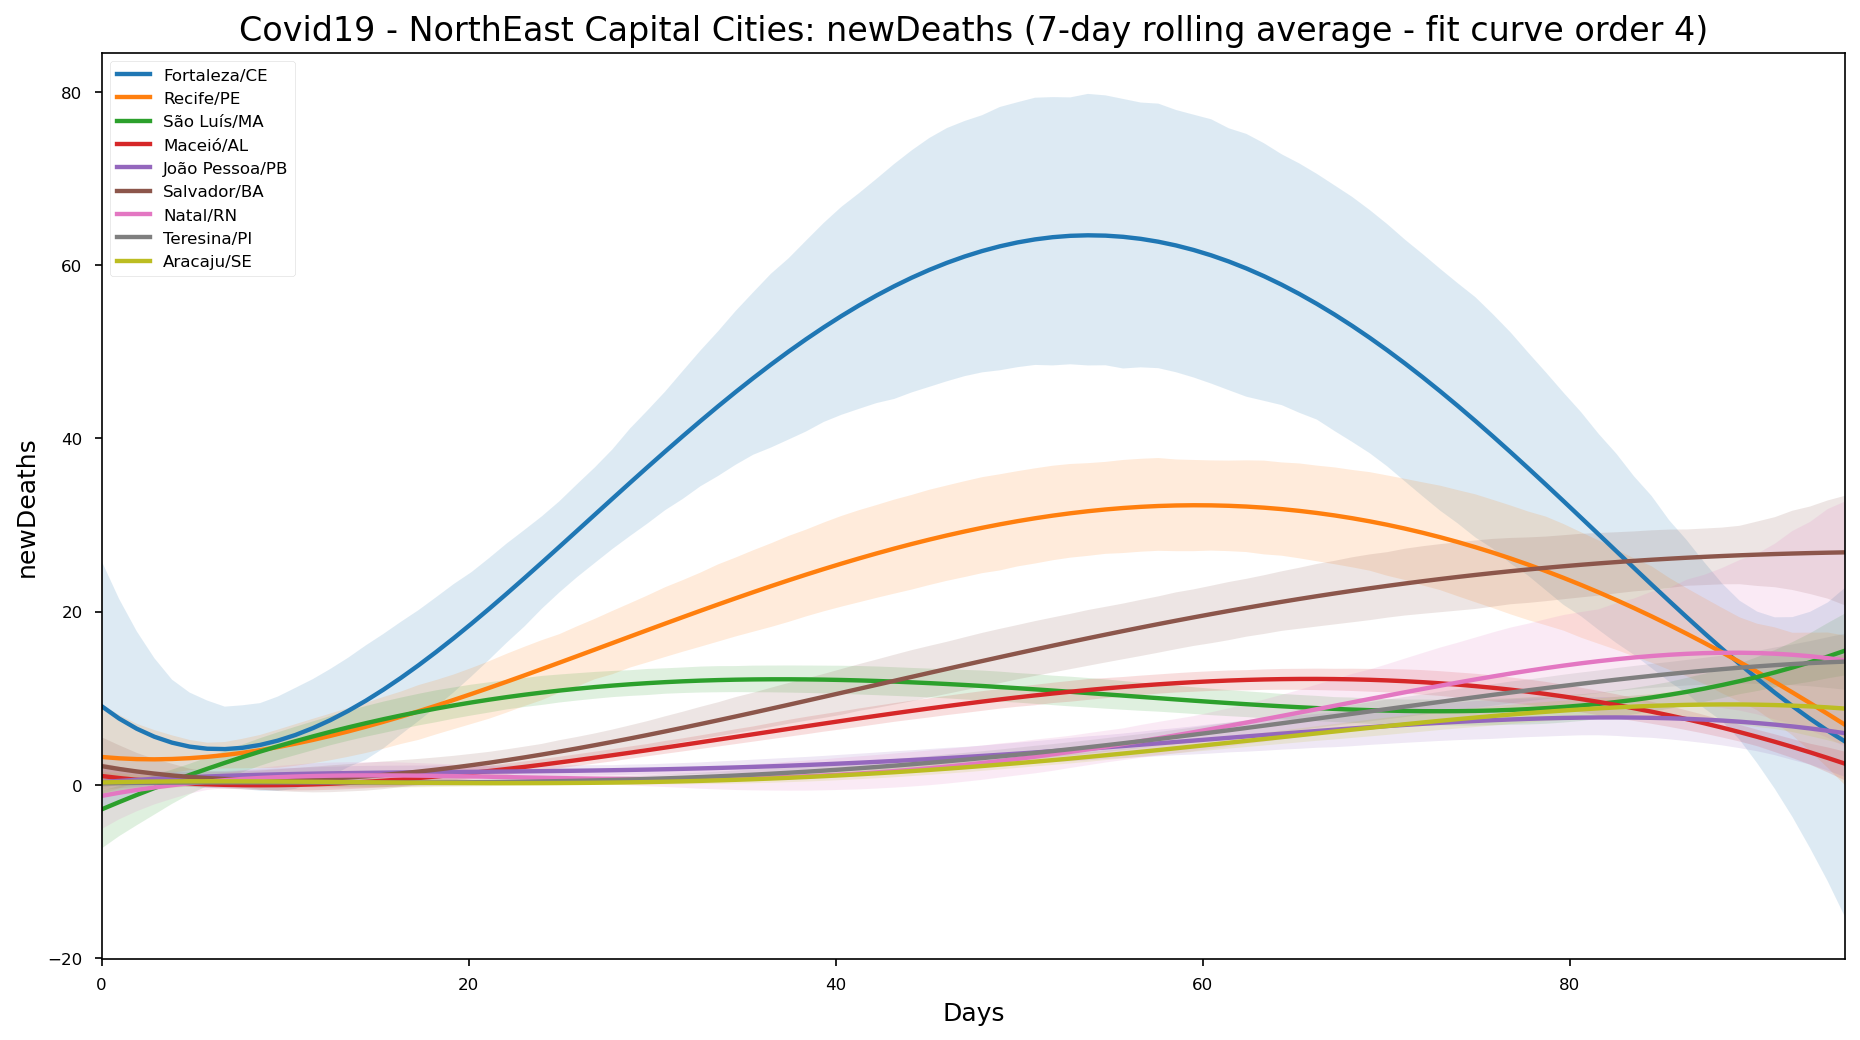

In [60]:
dx = plot_cities(dt_tm, NE_capital_cities, feature = 'newDeaths', title = 'NorthEast Capital Cities', mov=7, order=4)

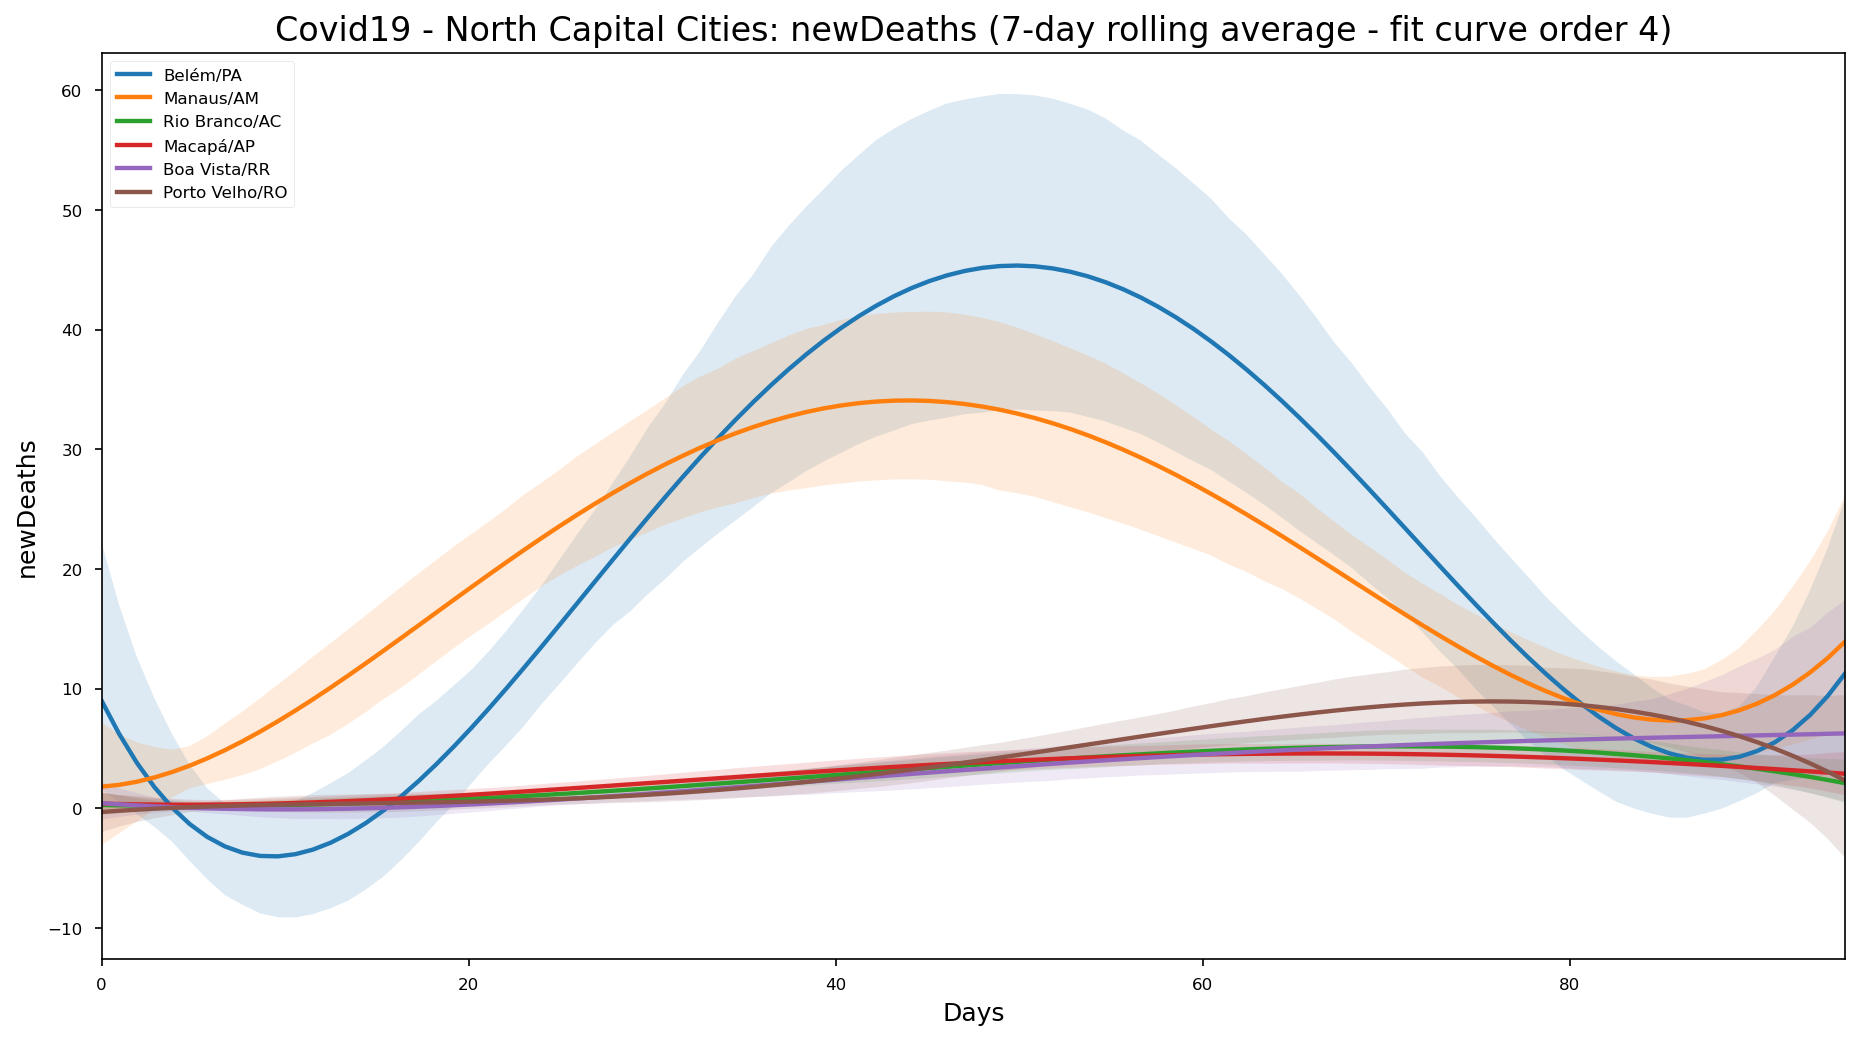

In [61]:
dx = plot_cities(dt_tm, N_capital_cities, feature = 'newDeaths', title = 'North Capital Cities', mov=7, order=4)

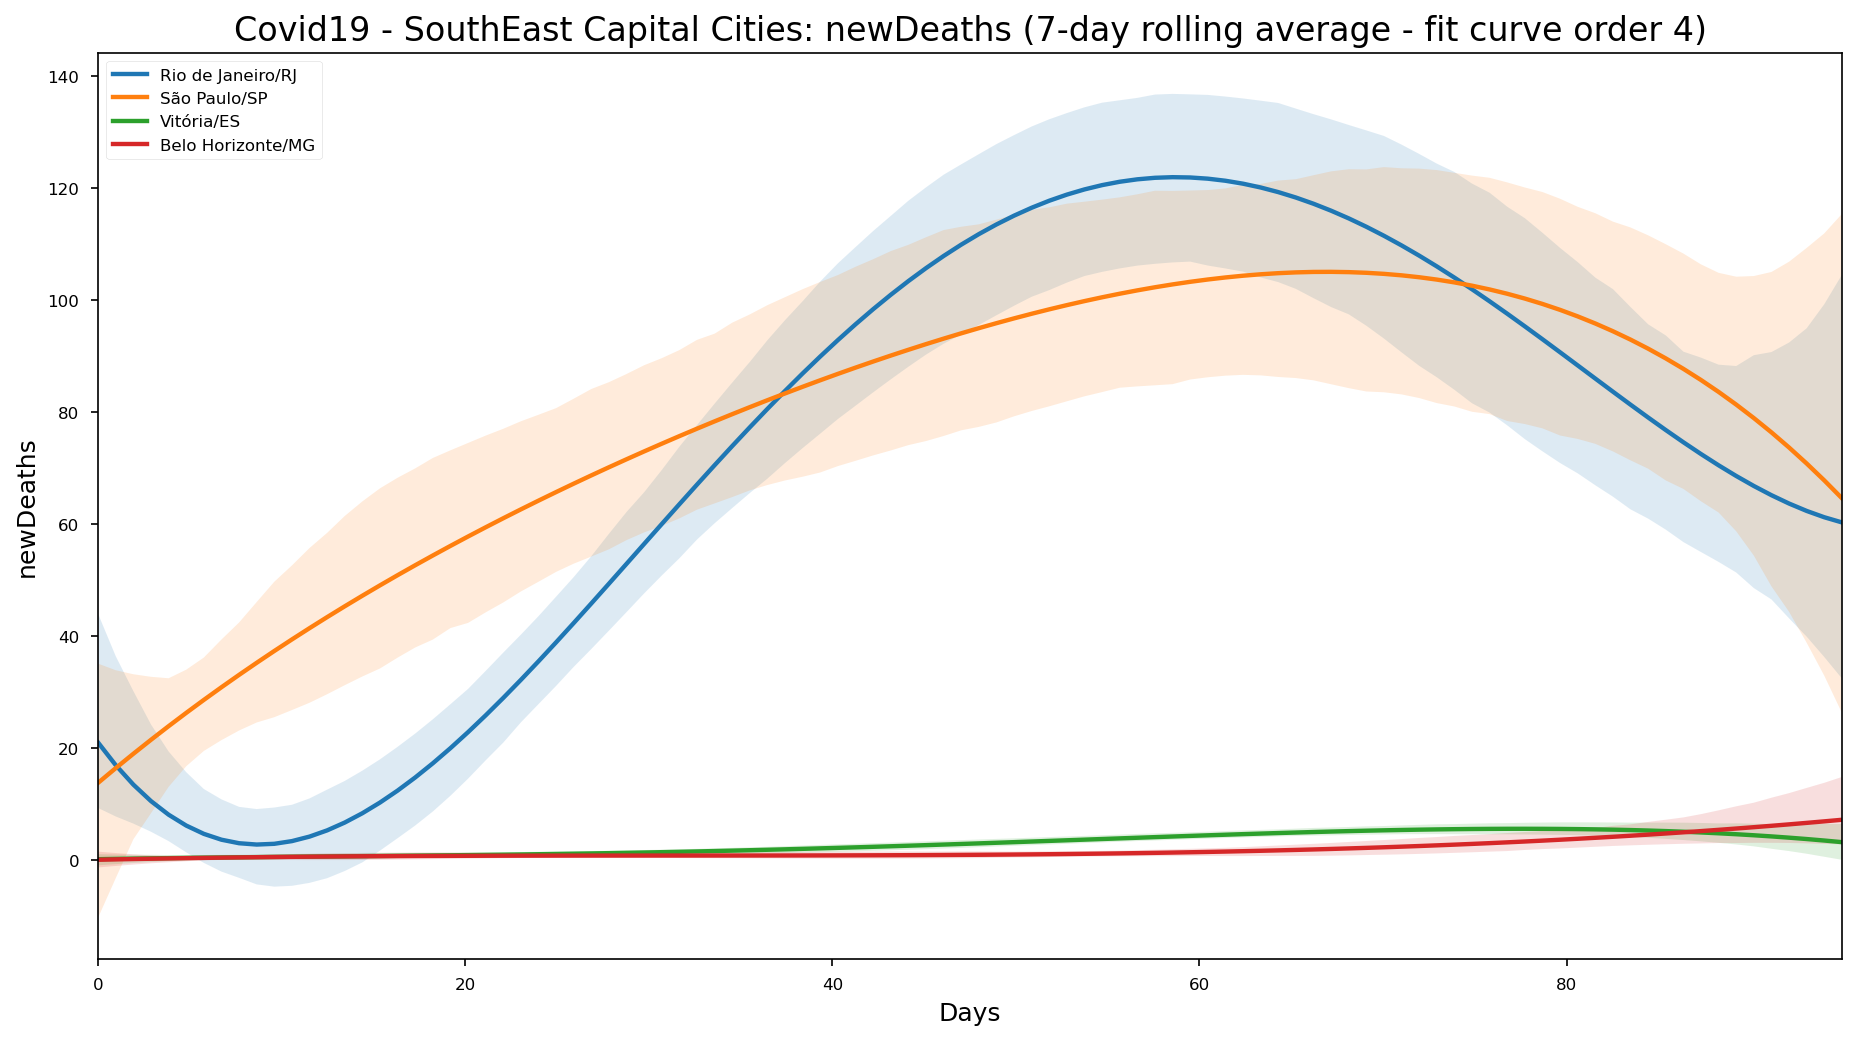

In [62]:
dx = plot_cities(dt_tm, SE_capital_cities, feature = 'newDeaths', title = 'SouthEast Capital Cities', mov=7, order=4)

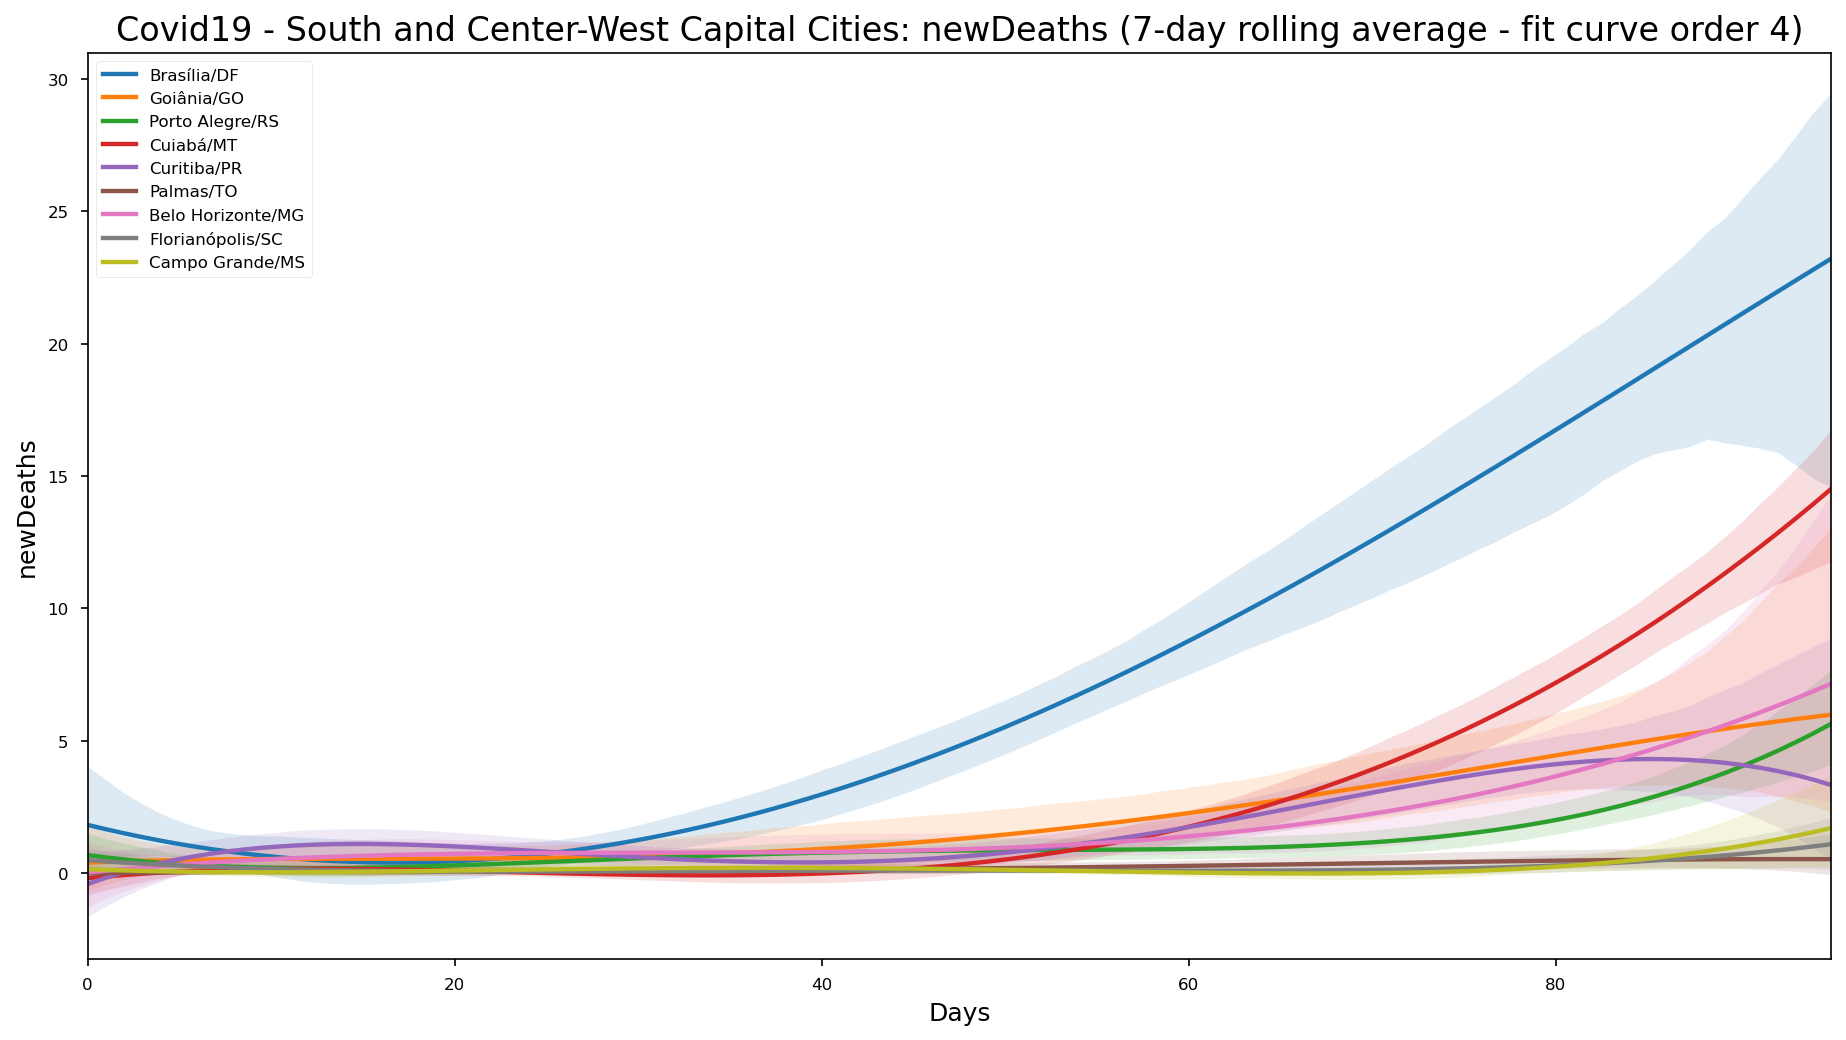

In [63]:
dx = plot_cities(dt_tm, S_CO_capital_cities, feature = 'newDeaths', title = 'South and Center-West Capital Cities', mov=7, order=4)

## Bar Race

In [64]:
bcr.bar_chart_race(dead_city, 
                   title='Brazil Top Cities with COVID-19 cases - Deaths per 100K inhabitants',
                   filename=None)

NameError: name 'dead_city' is not defined

In [ ]:
bcr.bar_chart_race(dead_city, 
                   title='Brazil Top Cities with COVID-19 cases - Deaths per 100K inhabitants',
                  filename='../videos/top_cities_deaths_100K.mp4')

In [ ]:
br_capital_cities = ['Belém', 
'Fortaleza',
'Recife',
'Manaus',
'Rio de Janeiro',
'São Luís',
'São Paulo',
'Maceió',
'Rio Branco',
'Vitória',
'Macapá',
'Boa Vista',
'Porto Velho',
'João Pessoa',
'Salvador',
'Natal',
'Teresina',
'Aracaju',
'Brasília',
'Goiânia',
'Porto Alegre',
'Cuiabá',
'Curitiba',
'Palmas',
'Belo Horizonte',
'Florianópolis',
'Campo Grande']

In [ ]:
capital_cities = ['Belém/PA', 
'Fortaleza/CE',
'Recife/PE',
'Manaus/AM',
'Rio de Janeiro/RJ',
'São Luís/MA',
'São Paulo/SP',
'Maceió/AL',
'Rio Branco/AC',
'Vitória/ES',
'Macapá/AP',
'Boa Vista/RR',
'Porto Velho/RO',
'João Pessoa/PB',
'Salvador/BA',
'Natal/RN',
'Teresina/PI',
'Aracaju/SE',
'Brasília/DF',
'Goiânia/GO',
'Porto Alegre/RS',
'Cuiabá/MT',
'Curitiba/PR',
'Palmas/TO',
'Belo Horizonte/MG',
'Florianópolis/SC',
'Campo Grande/MS']

In [ ]:
dead_capital = get_dataframe(df=dt_tm,
                          cities=capital_cities,
                          feature='deaths_per_100k_inhabitants',
                          rnd=0,
                          in_data='2020-03-20')

In [ ]:
dead_capital

In [ ]:
bcr.bar_chart_race(dead_capital, 
                   title='Brazil Capital Cities - COVID-19 - Deaths per 100K inhabitants',
                   filename=None)

In [ ]:
bcr.bar_chart_race(dead_capital, 
                   title='Brazil Capital Cities - COVID-19 - Deaths per 100K inhabitants',
                  filename='../videos/capital_cities_deaths_100K.mp4')

In [ ]:
top_cities_deaths

In [ ]:
dead_top_city = get_dataframe(df=dt_tm,
                          cities=top_cities_deaths,
                          feature='deaths_per_100k_inhabitants',
                          rnd=0,
                          in_data='2020-03-20')

In [ ]:
bcr.bar_chart_race(dead_top_city, 
                   title='Brazil Top Cities - COVID-19 - Deaths per 100K inhabitants',
                   filename=None)

In [ ]:
bcr.bar_chart_race(dead_top_city, 
                   title='Brazil Top Cities - COVID-19 - Deaths per 100K inhabitants',
                  filename='../videos/top_death_cities_deaths_100K.mp4')

# SRAG - FioCruz

In [ ]:
url = 'https://gitlab.procc.fiocruz.br/mave/repo/-/raw/master/Dados/InfoGripe/serie_temporal_com_estimativas_recentes.csv'

In [ ]:
srag = pd.read_csv(url, sep=';')
srag.shape

In [ ]:
srag.head()

In [ ]:
srag.info()

In [ ]:
srag['Unidade da Federação'].value_counts()

In [ ]:
srag.dado.value_counts()

In [ ]:
srag['Total reportado até a última atualização'] = srag['Total reportado até a última atualização'].

In [ ]:
srag_mg = srag[srag['Unidade da Federação'] == 'Minas Gerais']

In [ ]:
srag_mg.head()